# <center> [👀🚗 Визуализация. Ошибки модели](https://stepik.org/lesson/826359/) </center>

### Оглавление ноутбука

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">📊 Важность фичей </a></li>
<li><a href="#c2">📂 SHAP values :</a></li>
<li><a href="#look1"> 📦 classification report </a>
<li><a href="#look1"> 👁‍ Матрица смежности </a>
<li><a href="#check1"> 📈 Регрессия и остатки</a>  
<li><a href="#check1"> 🤷‍ График (True - Pred) vs (True + Pred) </a>

<li><a href="#6">🧸 Выводы и заключения</a>

</li></ul></font></p>

<center> <img src='https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/images/viz_mistakes.JPG'/>

<div class="alert alert-info">
    
* Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:
    * Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки
    * Сделать выводы, как можно улучшить точность в последующих экспериментах.
    * Визуализировать ошибки модели
    * Отсеять лишние признаки
    * Найти идеи для новых признаков.
    * Все зависит от типа ваших данных

In [ ]:
!pip install catboost sklearn shap seaborn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 40.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,random_feature_1,random_feature_2,random_feature_3
1319,K11706281f,Renault Kaptur,standart,petrol,3.40,2015,85456,2019,48.65,engine_overheat,4.290862,1.378842e+07,0.1,187.050729,1.249491,174,168,0.156520,-0.472006,63
1314,u-1483442N,Mini Cooper,business,petrol,5.40,2012,22537,2015,74.57,engine_check,4.978793,1.432070e+07,0.1,160.000000,-6.068228,174,171,0.658368,-0.152997,34
1148,c-8145167j,VW Tiguan,economy,petrol,5.98,2013,48745,2021,34.69,electro_bug,4.024138,1.336163e+07,0.0,187.907280,7.920123,174,172,0.828321,-2.456773,78


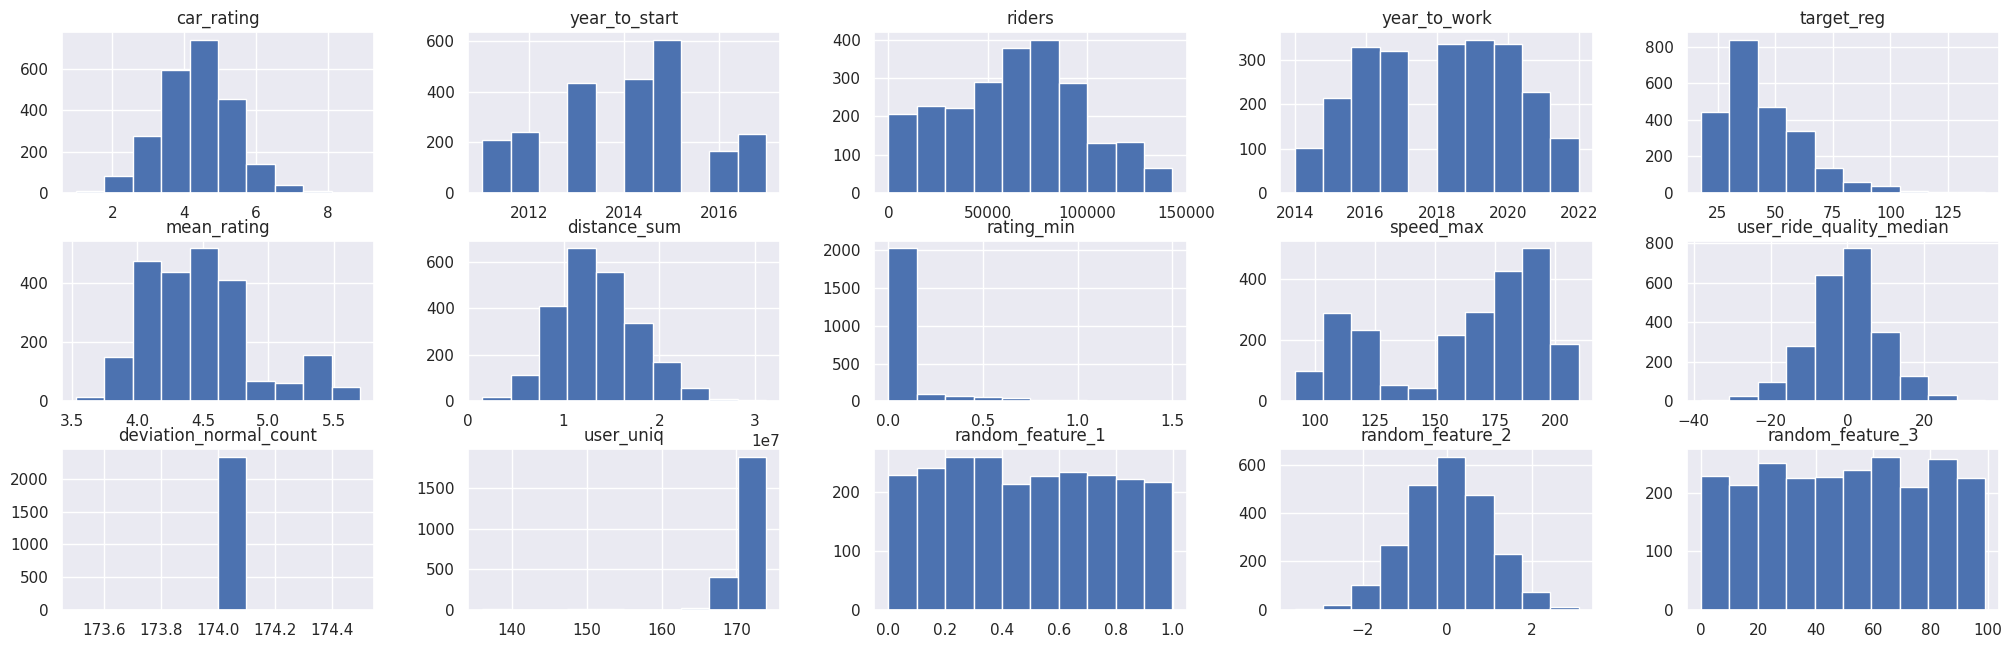

In [ ]:
data_root = "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/"
path = data_root + "quickstart_train.csv"
train = pd.read_csv(path)

# Добавим пару рандомных признаков для последующего анализа
train['random_feature_1'] = np.random.random(size = train.shape[0])
train['random_feature_2'] = np.random.normal(size = train.shape[0])
train['random_feature_3'] = np.random.randint(100, size = train.shape[0])

train.hist(figsize=(25, 7.5), layout=(-1, 5))
train.sample(3)

In [ ]:
from sklearn.model_selection import train_test_split

drop_cols = ['user_id', 'car_id', 'ride_id', 'ride_date']
cat_cols = ['car_type', 'fuel_type', 'model']

y = train['target_class']
X = train.drop(drop_cols + ['target_reg', 'target_class'], axis=1, errors = 'ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# <center> 🤹‍♀️ Классификация

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                        colsample_bylevel =  0.1,
                        subsample = 0.95,
                        bootstrap_type='Bernoulli')

clf.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=250,
        plot=False,
        early_stopping_rounds=100)

print(clf.get_best_score())

Learning rate set to 0.109335
0:	learn: 2.0415376	test: 2.0431216	best: 2.0431216 (0)	total: 6.87ms	remaining: 6.86s
250:	learn: 0.3360109	test: 0.5422472	best: 0.5421275 (248)	total: 1.36s	remaining: 4.06s
500:	learn: 0.2132003	test: 0.5310465	best: 0.5296667 (420)	total: 2.73s	remaining: 2.71s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5296667299
bestIteration = 420

Shrink model to first 421 iterations.
{'learn': {'MultiClass': 0.2085335300825983}, 'validation': {'MultiClass': 0.529666729929534}}


# <center> Визуализируем важность фичей для `Catboost`


In [ ]:
# Посмотрим важность признаков
fi = clf.get_feature_importance(prettified=True)
fi[:20] # .style.background_gradient(cmap='viridis', subset=pd.IndexSlice[0:10, 'Importances'])

,Feature Id,Importances
0,speed_max,34.625519
1,mean_rating,29.034345
2,rating_min,12.358860
3,user_uniq,3.766644
4,car_type,3.001247
5,user_ride_quality_median,2.206731
6,model,1.964647
7,car_rating,1.944201
8,random_feature_1,1.797706
9,random_feature_3,1.660259



Не стоит сильно доверять этому рейтингу важности, т.к. для сильно скоррелированных признаков импортанс делится пополам и они оба могут улететь вниз по важности.

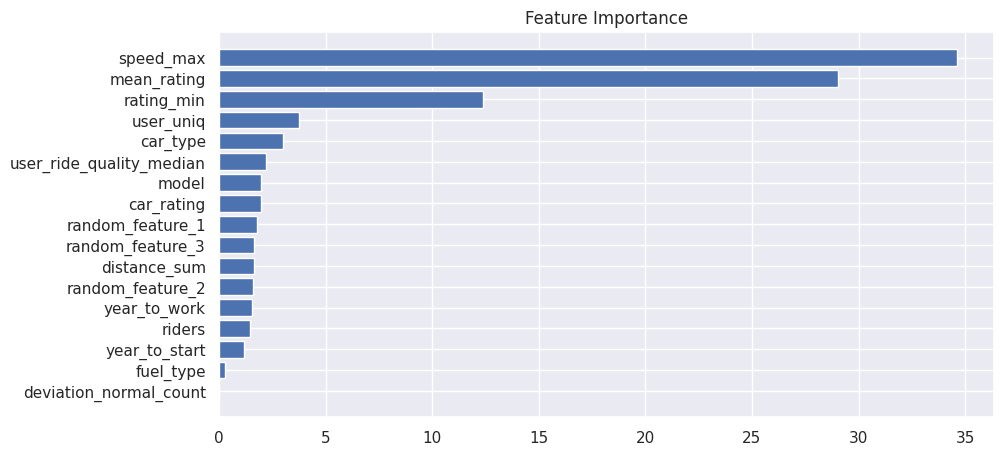

In [ ]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

##  **График важности признаков при кросс-валидации с помощью `Seaborn`**

In [ ]:
from sklearn.model_selection import KFold

n_splits = 5
targets = ['target_class']
clfs = []
scores = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)

    clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                        colsample_bylevel =  0.1,
                        subsample = 0.95,
                        bootstrap_type='Bernoulli',)

    clfs.append(clf)

    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = False, use_best_model = True, plot = False)

    scores.append(np.mean([v for k, v in clf.best_score_['validation'].items()], dtype = 'float16'))

print('mean recall score --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))

mean recall score ---------> 0.4934 0.03018


## **Функция для отображения разброса важности признаков по фолдам.**

In [ ]:
#from src.utils import plot_importance
def plot_importance(df, best_model, height, top_n=50):

    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]

    fi = fi[fi['feature'].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)

    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

# df_feats_imp = plot_importance(train[filtered_features].drop(targets, axis=1, errors='ignore'), clfs, 0.20, top_n=100)

Всего признаков 17 Усреднее по 5-ти моделям: 
На график нанесено топ-14 признаков


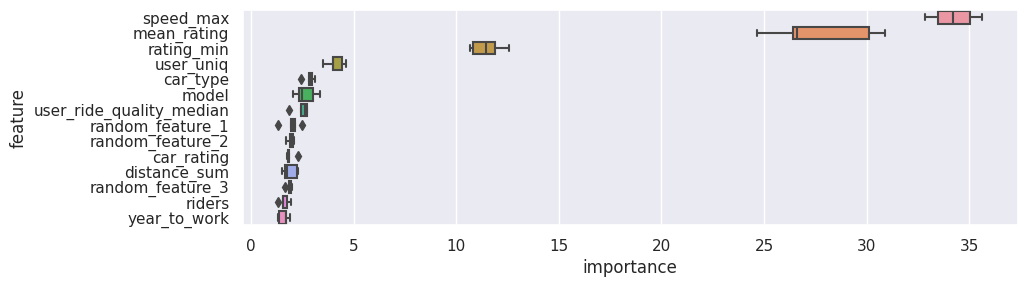

In [ ]:
# Строим важность по всем фолдам сразу
df_feats_imp = plot_importance(X, clfs, height = 0.20, top_n = 14)

**Посмотрим на графики важности более точных методов**

## <center><b> 🔁 Permutation importance </b></center>

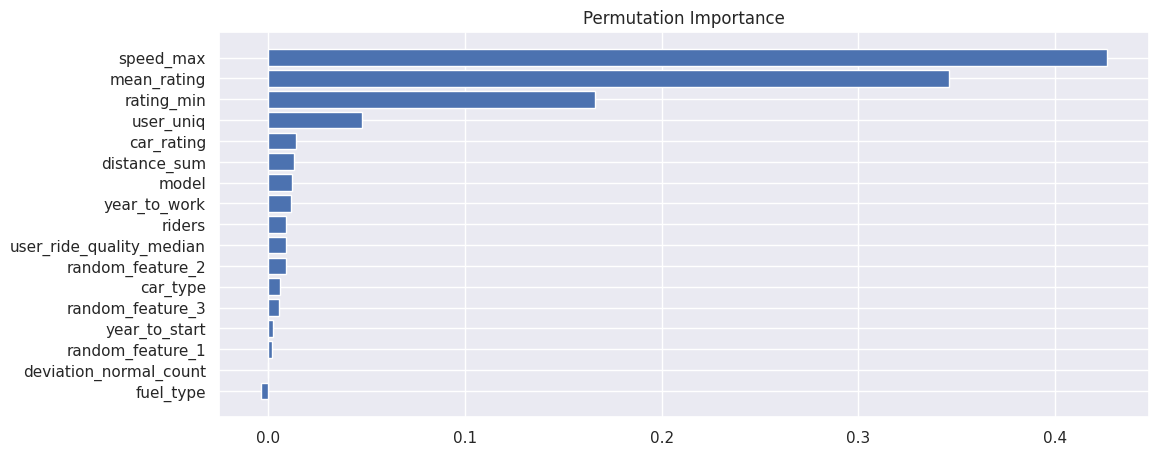

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png">

<div class="alert alert-info">
    
В библиотеке SHAP для оценки важности признаков рассчитываются значения Шэпли (по имени американского математика и названа библиотека), она обладает богатым функционалом визуализации, который помогает легко и просто объяснить модель.

Для оценки важности фичи происходит оценка предсказаний модели с и без данной фичи.

In [ ]:
# Библиотека shap бывает капризна в установке и может конфликтовать с другими пакетами
# Иногда помогает такой набор команд
#!pip uninstall opencv-python -y -q
#!pip install opencv-python shap -q

In [ ]:
import shap
shap.initjs()

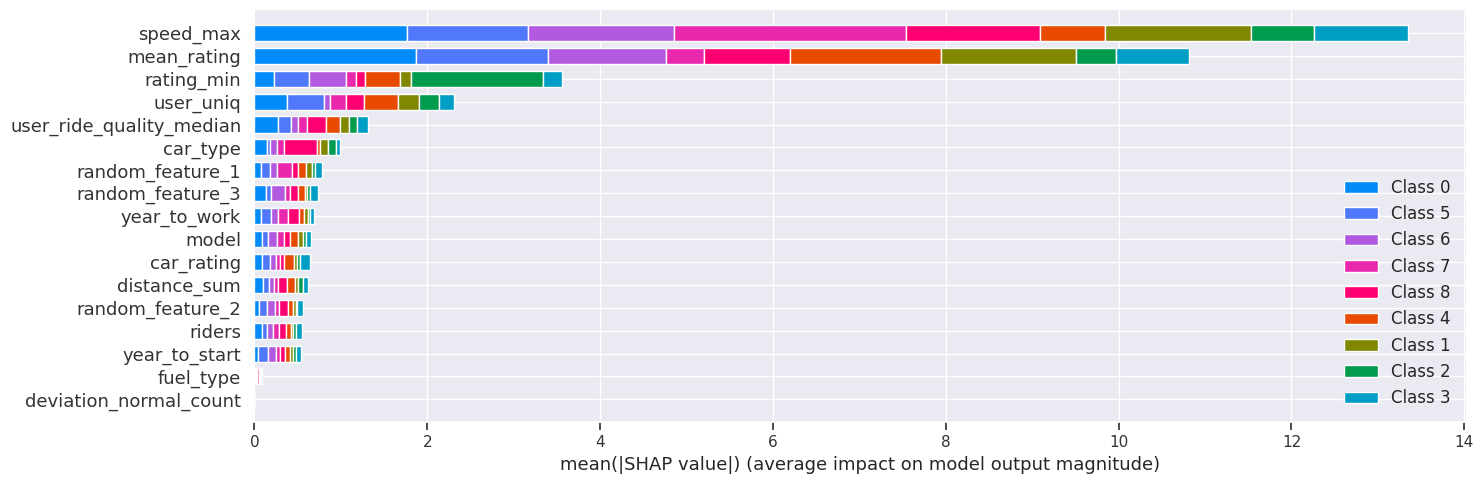

In [ ]:
# Можем посмотреть влияние фичей на все классы
explainer = shap.TreeExplainer(clf)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25, plot_size = (15, 5))

Class 0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


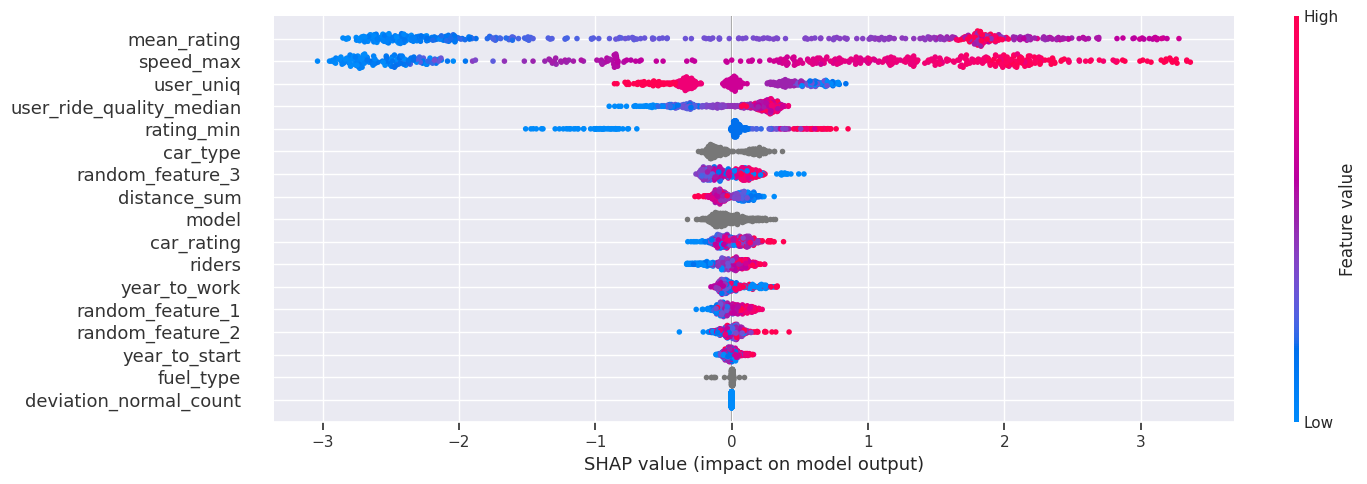

Class 1


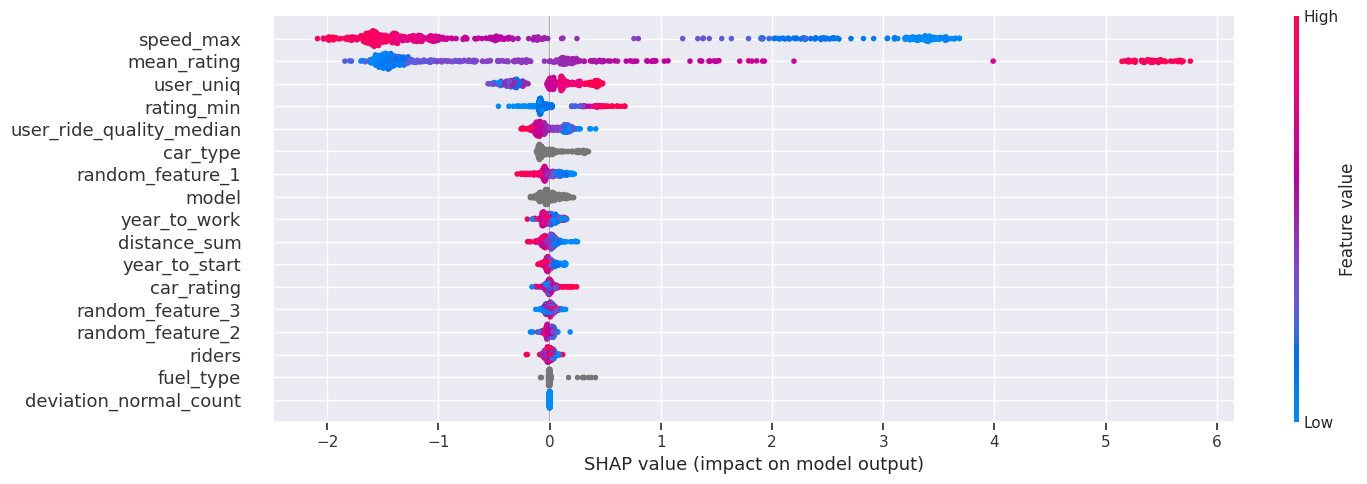

In [ ]:
# Или на каждый класс по отдельности
for i in range(len(np.unique(y.values))):
    print(f'Class {i}')
    shap.summary_plot(shap_values[i], X_test, color_bar=True, plot_size = (15, 5))
    if i == 1:
        break
# shap.summary_plot(shap_values[1], X_test, color_bar=False)

# 📚 Как читать график?

<div class="alert alert-info">

* значения слева от центральной вертикальной линии — это **negative** класс (0), справа — **positive** (1)
* чем толще линия на графике, тем больше таких точек наблюдения
* чем краснее точки на графике, тем выше значения фичи в ней

# <center>🤙 dependence_plot

<div class="alert alert-info">
    
Мы можем посмотреть влияние отдельной фичи на конкретный класс с помощью `dependence_plot`

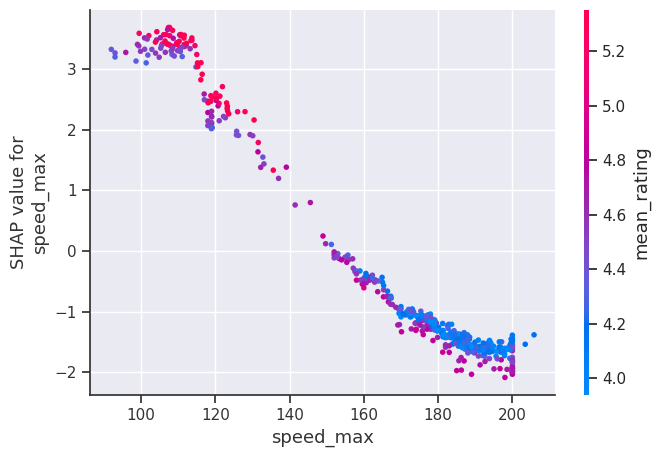

In [ ]:
shap.dependence_plot("speed_max", shap_values[1], X_test)

<div class="alert alert-info">
    
    
Одна из самых крутых фишек баблиотеки SHAP, это возможность посмотреть как модель опрделяет к какому классу относится конкретная машина, и какие признаки на это влияют.
Посмотрим на примере первой машины из тестовой выборки.

In [ ]:
X_test.iloc[0]

model                       Renault Sandero
car_type                           standart
fuel_type                            petrol
car_rating                              4.7
year_to_start                          2012
riders                                26428
year_to_work                           2017
mean_rating                        4.181149
distance_sum                13983174.664416
rating_min                              0.1
speed_max                        203.462289
user_ride_quality_median         -14.260456
deviation_normal_count                  174
user_uniq                               171
random_feature_1                   0.548451
random_feature_2                   1.714561
random_feature_3                         99
Name: 4, dtype: object

In [ ]:
# поломка "engine_fuel" это 4 класс
y_test.iloc[0]

'engine_fuel'

# <center> 💪 force_plot

<div class="alert alert-info">
      
* В этом нам помогут `force_plot` и просто "пушечный" вид графика `waterfall_plot`.
* Можно посмотреть на вклад каждого признака в то, что модель не отнесла поломку машины к классу 0 и отнесла к классу 4

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=X_test.columns)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[4][0], feature_names=X_test.columns)

# <center> 💧 waterfall_plot

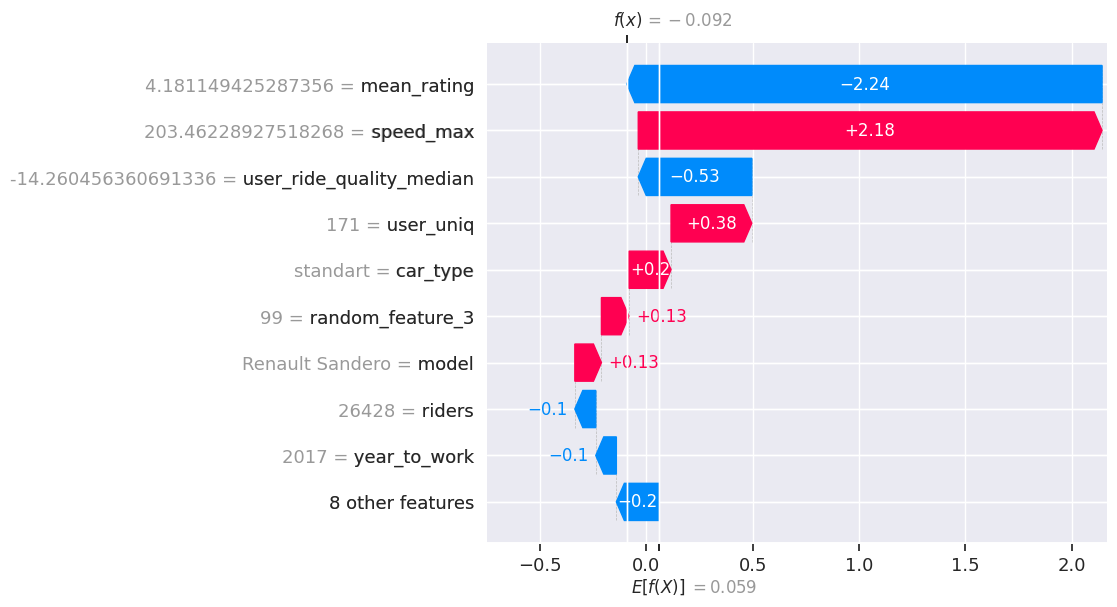

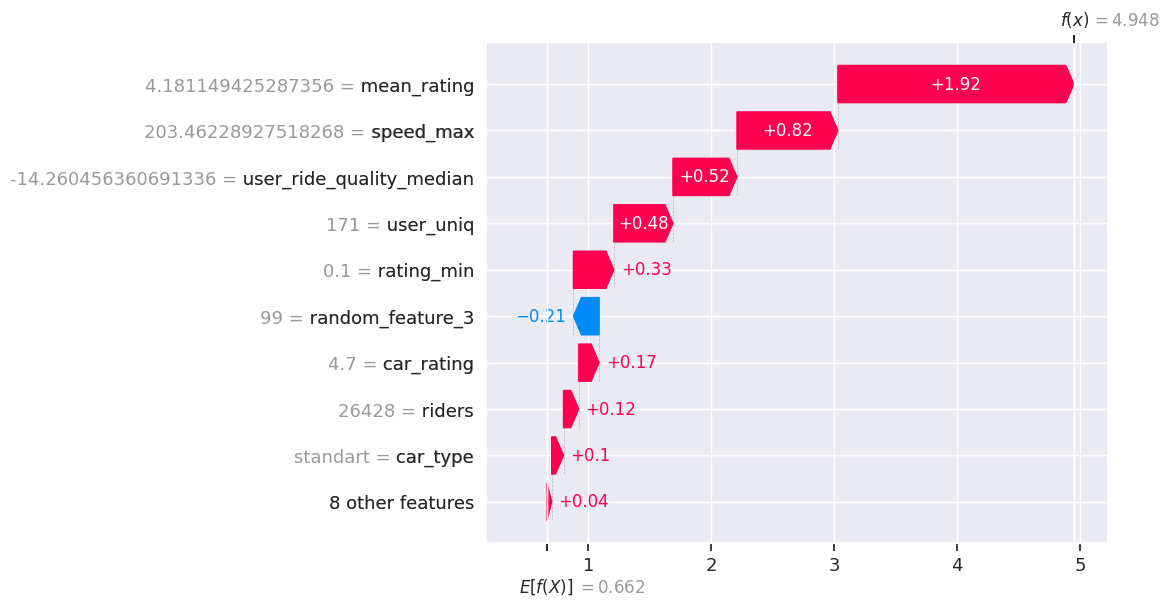

In [ ]:
# waterfall_plot показывает численное влияние каждого признака
s_values = explainer(X_test)
shap.waterfall_plot(s_values[0][:, 0])
shap.waterfall_plot(s_values[0][:, 4])

В библиотеке [SHAP](https://shap.readthedocs.io/en/latest/index.html) есть ещё большое количество других графиков, а мы показали самые интересные и часто используемые.

# <center> 📦 `classification_report` - одна функция и сразу все метрики </center>

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_))

                 precision    recall  f1-score   support

    another_bug       0.94      0.85      0.89        59
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        56
   engine_check       0.71      0.89      0.79        45
    engine_fuel       0.70      0.78      0.74        50
engine_ignition       0.60      0.46      0.52        61
engine_overheat       0.58      0.68      0.63        62
     gear_stick       0.96      0.90      0.92        48
    wheel_shake       0.81      0.70      0.75        30

       accuracy                           0.80       467
      macro avg       0.81      0.81      0.80       467
   weighted avg       0.81      0.80      0.80       467



In [ ]:
rep = pd.DataFrame(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_,
                            output_dict=True)).T
rep['support'] = rep.support.apply(int)
rep.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['another_bug':'wheel_shake', :'f1-score'])

,precision,recall,f1-score,support
another_bug,0.943396,0.847458,0.892857,59
break_bug,1.000000,1.000000,1.000000,56
electro_bug,1.000000,1.000000,1.000000,56
engine_check,0.714286,0.888889,0.792079,45
engine_fuel,0.696429,0.780000,0.735849,50
engine_ignition,0.595745,0.459016,0.518519,61
engine_overheat,0.583333,0.677419,0.626866,62
gear_stick,0.955556,0.895833,0.924731,48
wheel_shake,0.807692,0.700000,0.750000,30
accuracy,0.802998,0.802998,0.802998,0


# <center> 👁‍🗨 `confusion_matrix` - Матрица смежности ❎ </center>

Посмотрим в каких классах модель больше всего ошибается с помощью матрицы смежности

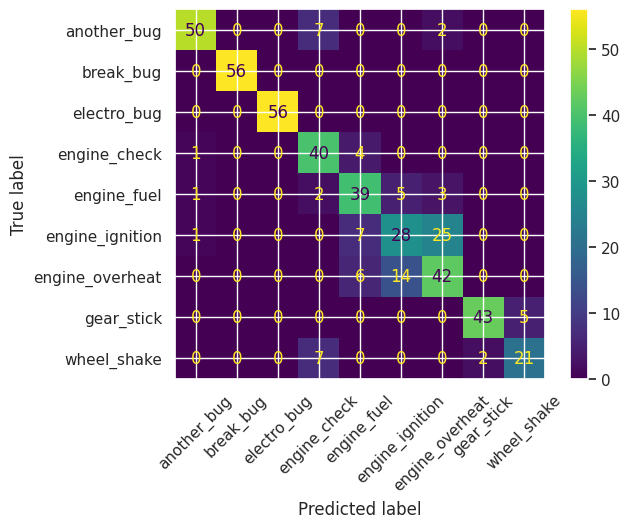

In [ ]:
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation = 45)
# Есть модель не под рукой
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation = 45)
# plt.show()

<Axes: >

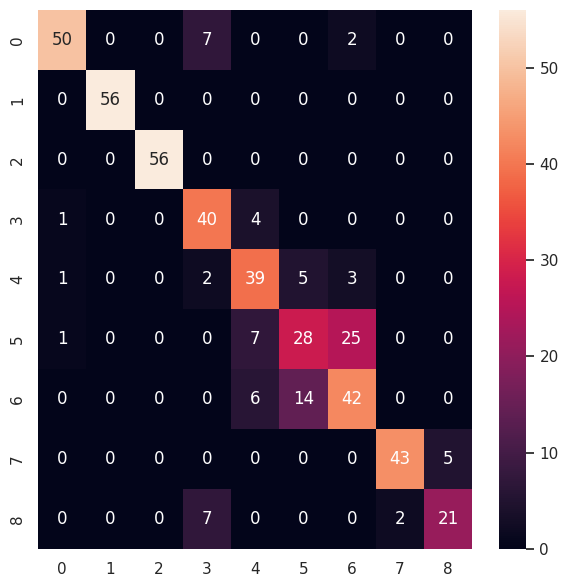

In [ ]:
plt.rcParams['figure.figsize']=(7, 7)
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True)

In [ ]:
#from src.utils import plot_confusion, plot_importance
def plot_confusion(Y_test, Y_test_pred, labels):
    cm = confusion_matrix(Y_test, Y_test_pred)
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in labels],
        columns=[i for i in labels])
    plt.figure(figsize=(6, 6))
    ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
    plt.setp(ax.get_xticklabels(), rotation=45)

    plt.ylabel('True label', fontweight='bold', fontsize = 14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize = 14)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

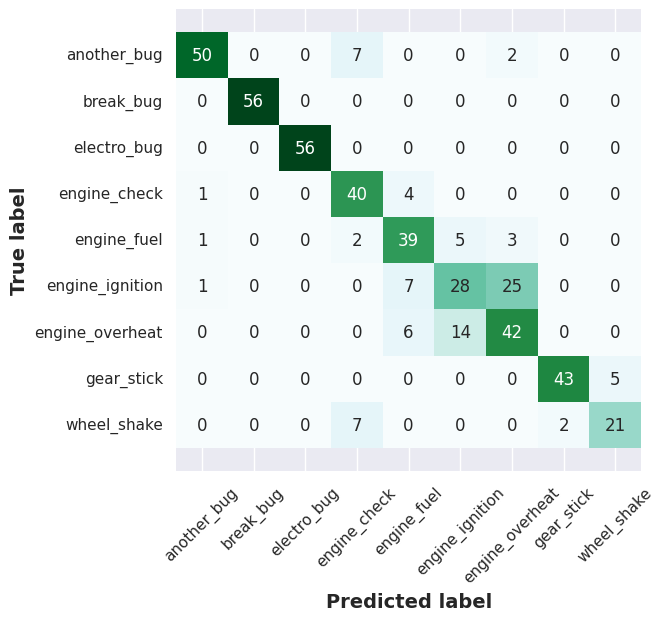

In [ ]:
# Тот же спсособ выше, только чуть причесанный
plot_confusion(Y_test = y_test, Y_test_pred = y_pred, labels = clf.classes_ )

# 📚 Как читать график?

<div class="alert alert-info">

* Значения диагонали сверху вниз слева направо – это число верно предсказанных значений.
* Чем темнее квадрат, тем больше верных ответов.
* Можно сделать вывод, что модель больше всего путается между классами: `1 - 2`, `1 - 5`, `1- 6`, `2 - 3`, `5 - 6`.
* В целом, видно, что 1 и 5 классы хуже отделяются.

In [ ]:
# !sudo apt update -y && sudo apt install graphviz -y -q

## Отрисуем дерево модели

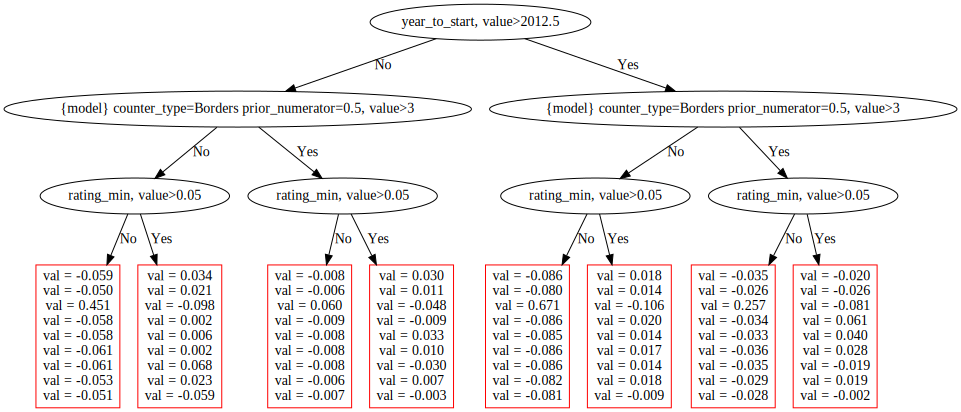

In [ ]:
# Как минимум помогает понять, что такое дерево решений
clf.plot_tree(
    tree_idx=4,
    pool=val_dataset
)

# <center> 💹 `Partial plots` - влияние признаков на прогноз</center>
 Посмотрим как топовые фичи влияют на прогноз модели

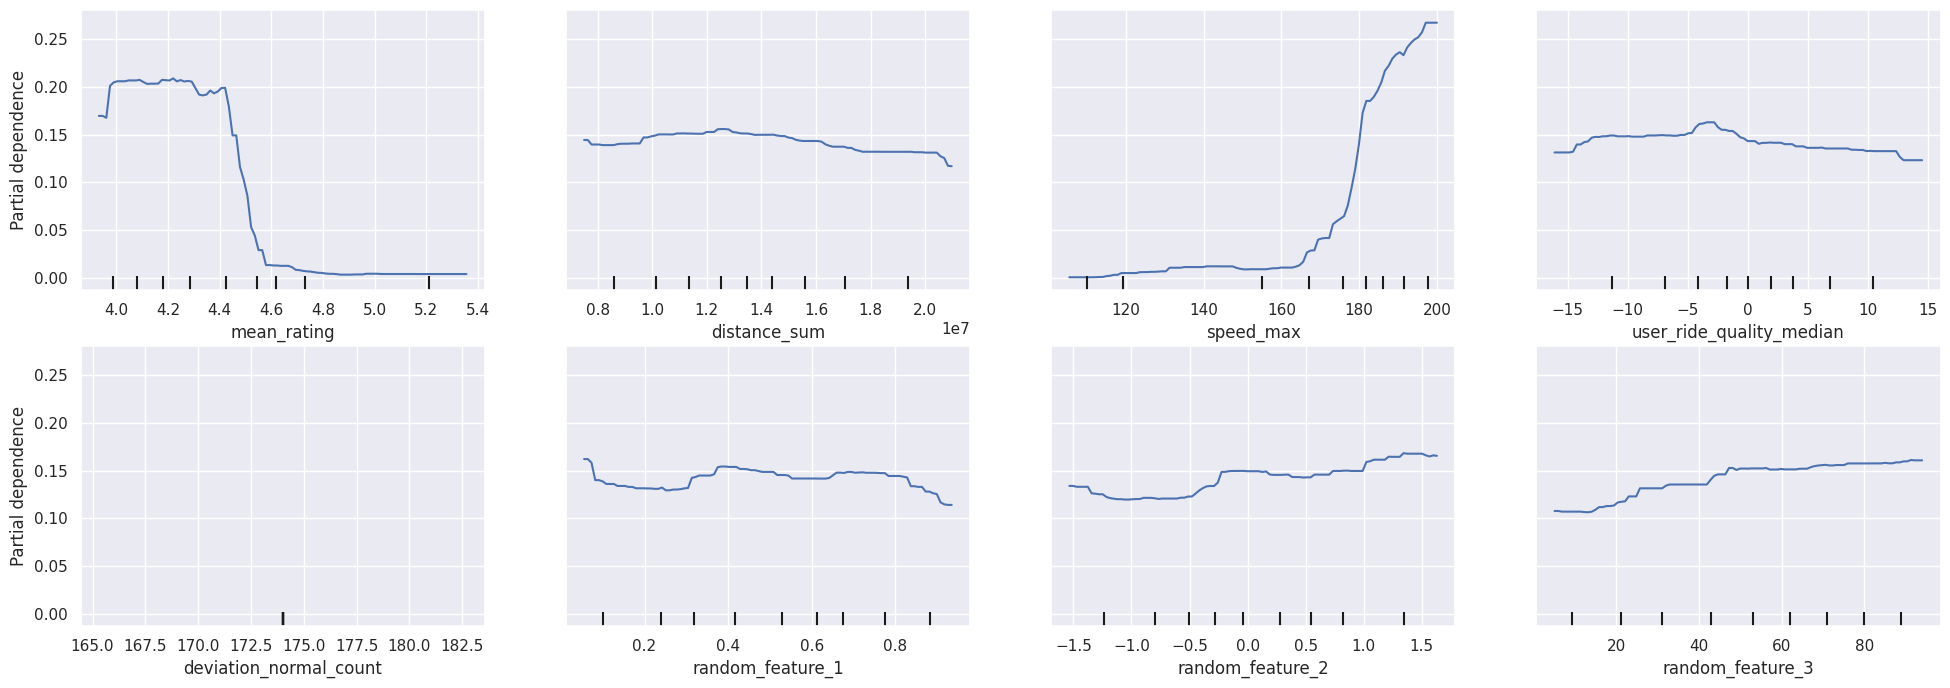

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

plt.rcParams['figure.figsize']=(24, 8)
features = X.drop(cat_cols, axis=1).columns

features = ['mean_rating', 'distance_sum', 'speed_max', 'user_ride_quality_median',
            'deviation_normal_count', 'random_feature_1', 'random_feature_2', 'random_feature_3']

PartialDependenceDisplay.from_estimator(clf, X_test,
                                        features = features,
                                        target='engine_overheat',
                                        n_cols=4,
                                        n_jobs=-1,
                                        random_state=42,)

# <center> 📈 Регрессия

In [ ]:
y = train['target_reg']
X = train.drop(drop_cols + ['target_reg','target_class'], axis=1, errors = 'ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
regr = CatBoostRegressor(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                         )

regr.fit( X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(regr.get_best_score())

Learning rate set to 0.056174
0:	learn: 17.0988040	test: 17.8186403	best: 17.8186403 (0)	total: 10.4ms	remaining: 10.3s
50:	learn: 11.1793825	test: 12.4133657	best: 12.4133657 (50)	total: 200ms	remaining: 3.72s
100:	learn: 10.4771126	test: 12.2310015	best: 12.2310015 (100)	total: 331ms	remaining: 2.94s
150:	learn: 9.8464216	test: 12.1769309	best: 12.1602630 (137)	total: 475ms	remaining: 2.67s
200:	learn: 9.1990225	test: 12.1906954	best: 12.1602630 (137)	total: 625ms	remaining: 2.48s
250:	learn: 8.7239186	test: 12.2238689	best: 12.1602630 (137)	total: 770ms	remaining: 2.3s
300:	learn: 8.2955601	test: 12.2560685	best: 12.1602630 (137)	total: 926ms	remaining: 2.15s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 12.16026301
bestIteration = 137

Shrink model to first 138 iterations.
{'learn': {'RMSE': 7.988549562329464}, 'validation': {'RMSE': 12.160263012749944}}


# <center> 🍇🐇 Смотрим на остатки
Когда делаем предсказание для задачи классификации, то, помимо метрики, также визуально оцениваем качество по  матрице ошибок. </br>
А когда делаете регрессию, куда смотреть?

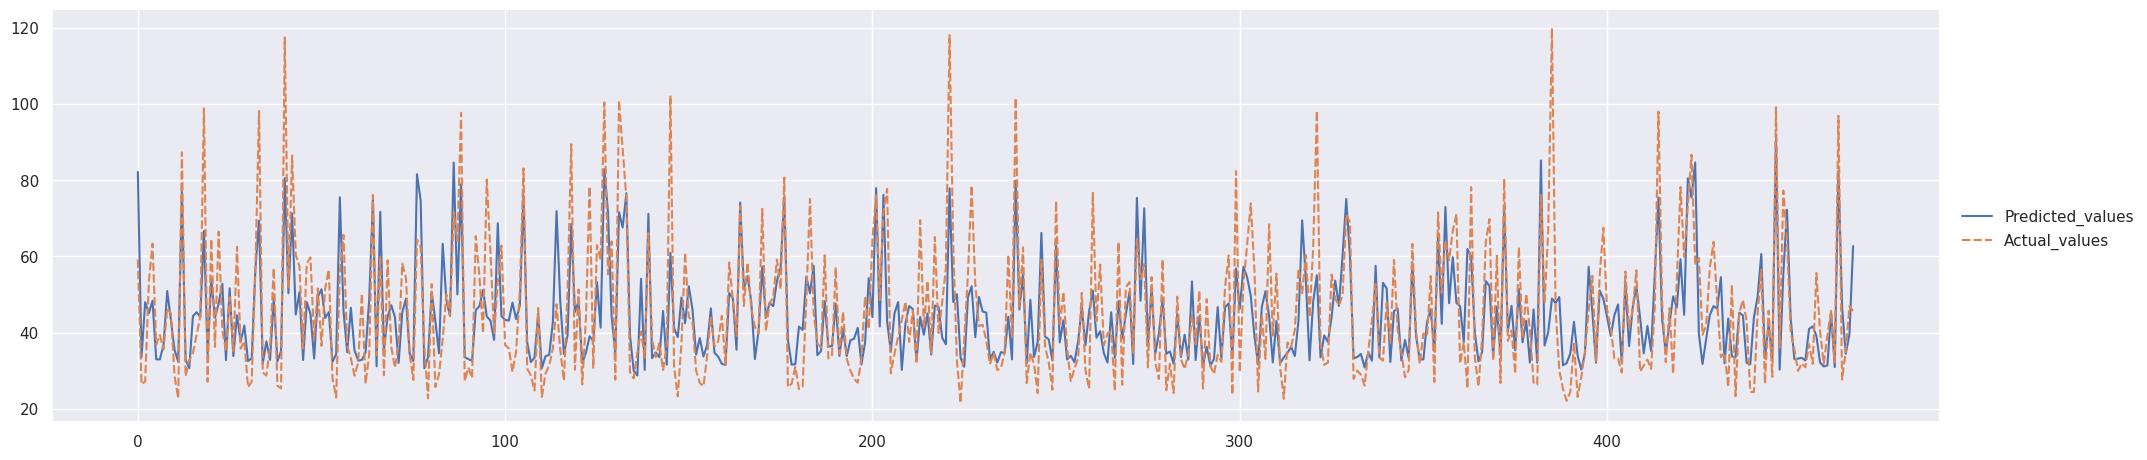

In [ ]:
cbr_prediction = regr.predict(X_test)

df_pred = pd.DataFrame(cbr_prediction, columns = ["Predicted_values"])
df_pred["Actual_values"] =  y_test.values

g = sns.relplot(data = df_pred, aspect = 4, kind = 'line')
# g.set(yscale="log")#.set(xscale="log")

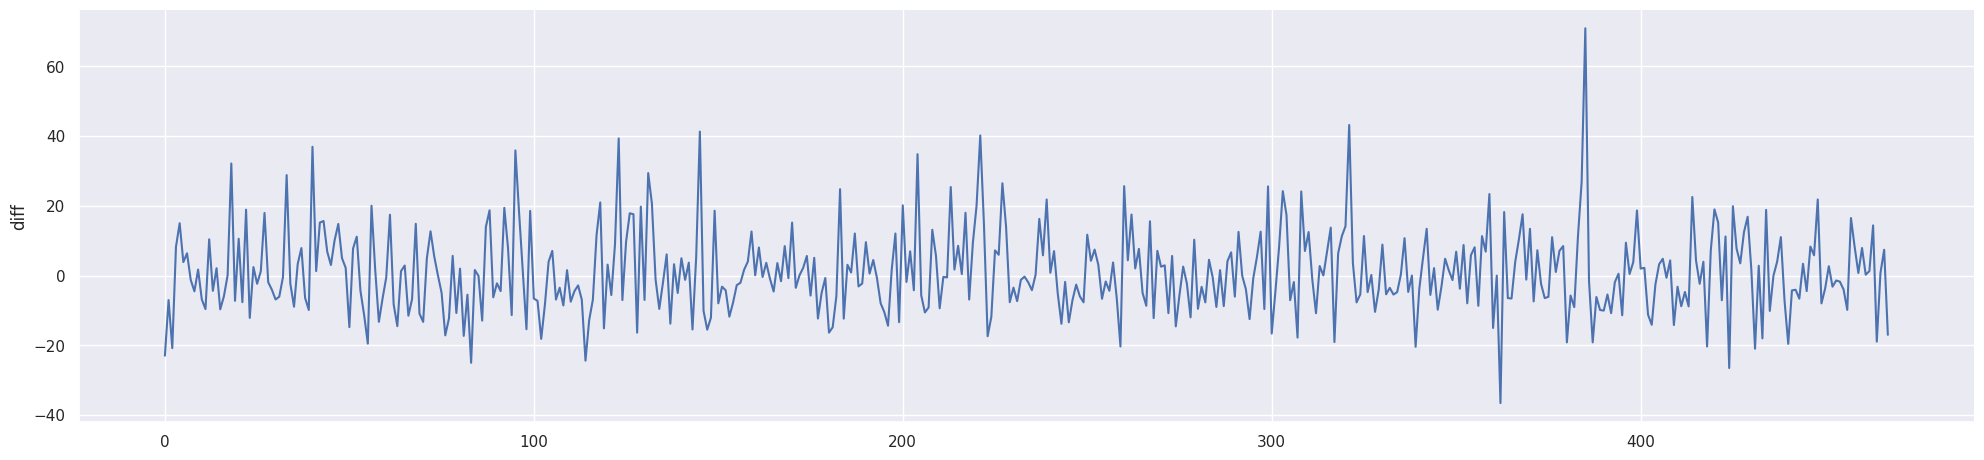

In [ ]:
df_pred['diff'] = df_pred["Actual_values"] - df_pred["Predicted_values"]
sns.relplot(data = df_pred['diff'], aspect = 4, kind = 'line')
# sns.displot(data = df_pred['diff'], aspect = 2, bins=60)

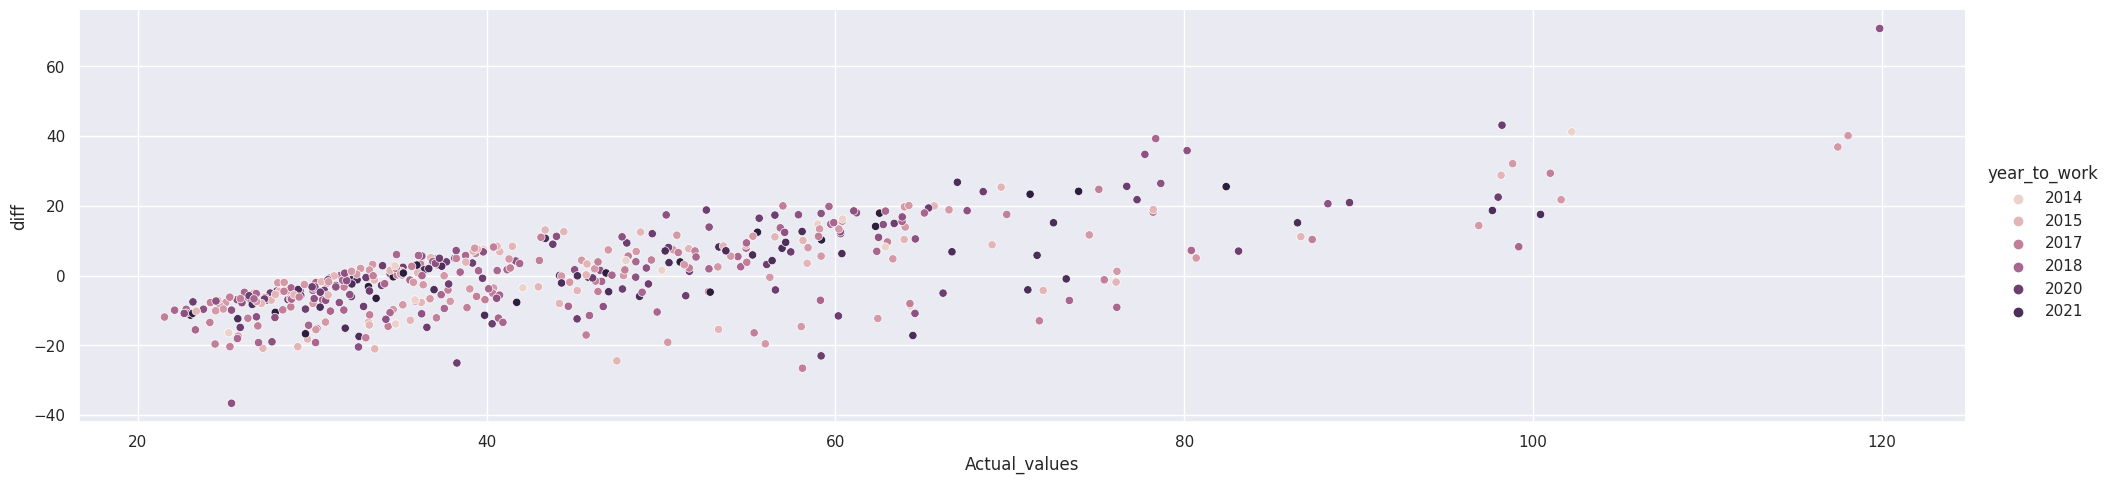

In [ ]:
df_pred['year_to_work'] = X_test["year_to_work"].values

g = sns.relplot(data = df_pred,
                x = 'Actual_values',
                y = 'diff',
                hue = 'year_to_work',
                kind = 'scatter',
                aspect = 4,)

# # g.set(yscale="log")#.set(xscale="log")

In [ ]:
df_pred['year_to_work'] = X_test["year_to_work"].values
# sns.displot(data = df_pred['diff'], aspect = 4, hue = 'year_to_work')

# <center> `Predicted` vs `Actual` значения

Еще два полезных графика:
* **Первый** - самый очевидный - просто отложить на двух осях фактические и предсказанные значения.
* **Второй** - изменить координаты на True-Pred и True+Pred. По сути, тот же вариант что и первый, но растянут по одной оси и сужен по второй.

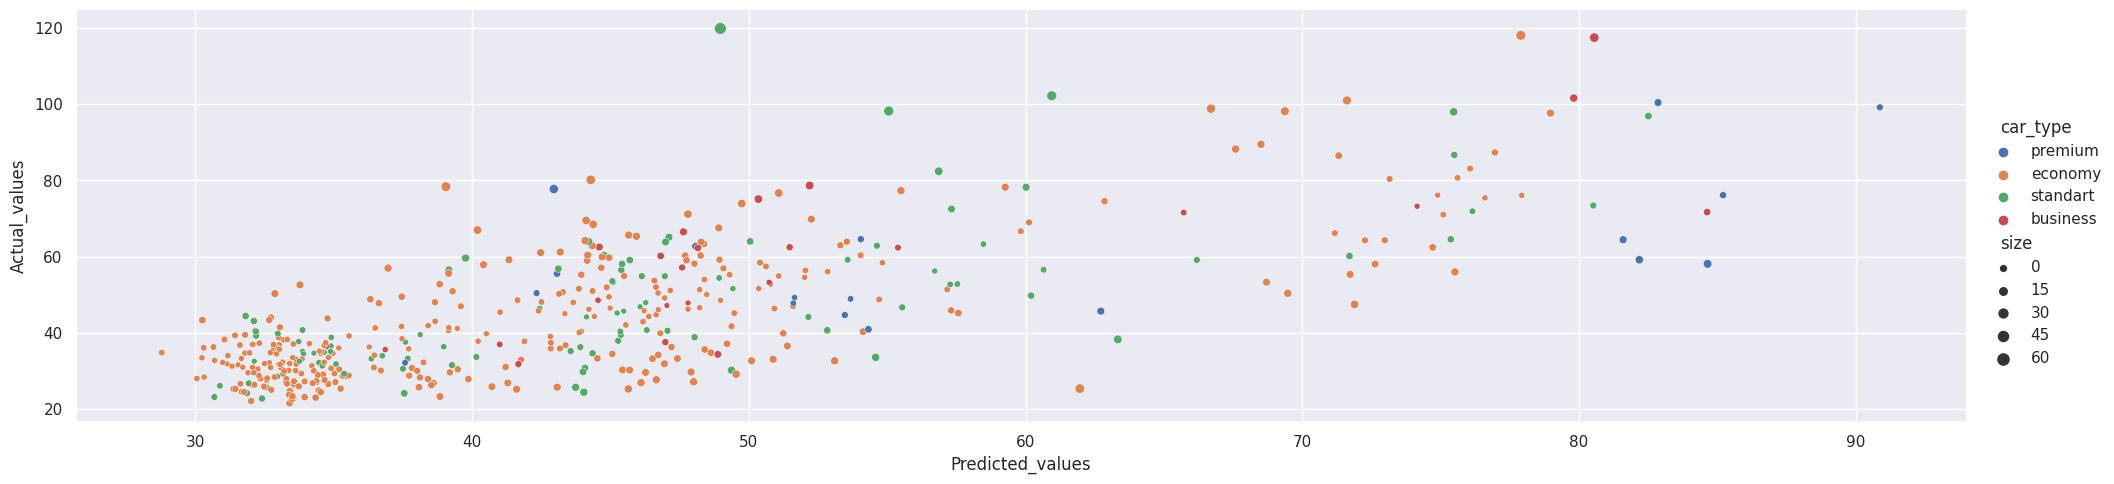

In [ ]:
df_pred['car_type'] = X_test['car_type'].values
df_pred['model'] = X_test['model'].values
df_pred['size'] = abs(df_pred["diff"] // 1)

g = sns.relplot(data = df_pred,
                x = 'Predicted_values',
                y = 'Actual_values',
                hue='car_type',
                size = 'size',
                aspect = 4,
                kind = 'scatter')

# g.set(yscale="log")#.set(xscale="log")

<div class="alert alert-info">
    
* В идеале, ответы должны быть по диагонали, но тут это не так. </br>
* Видно, чтот ответы в диапазоне больших значений предсказываются хуже. Возможно, с этим что-то можно сделать!
* Можно перебрать другие категориальные фичи

# <center> График (`True - Pred`) vs (`True + Pred`)

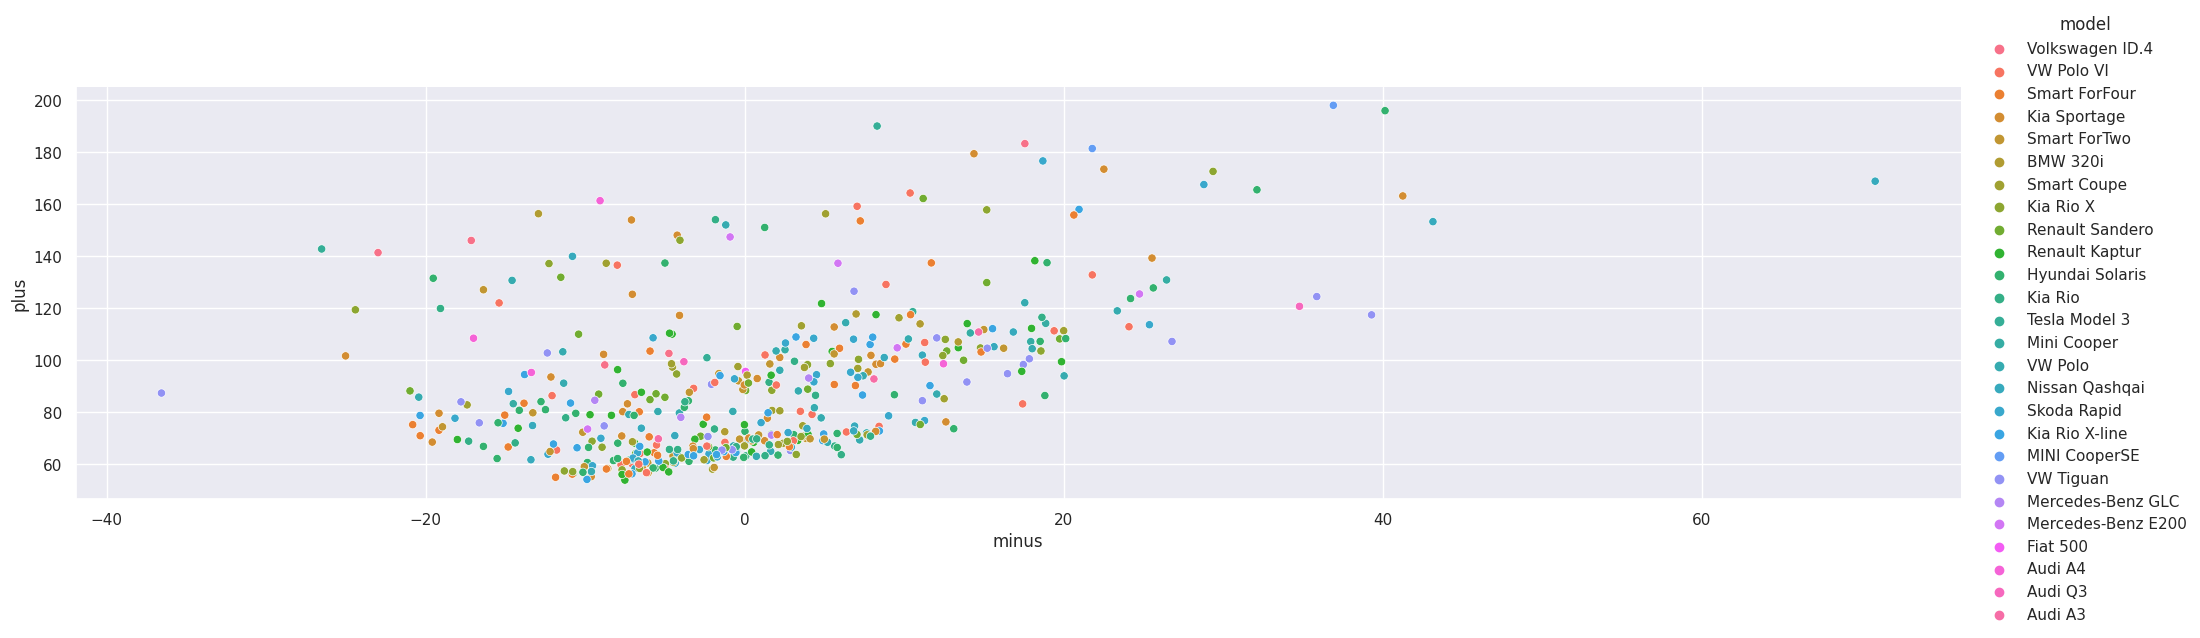

In [ ]:
df_pred['plus'] = df_pred["Actual_values"] + df_pred["Predicted_values"]
df_pred['minus'] = df_pred["Actual_values"] - df_pred["Predicted_values"]

g = sns.relplot(data = df_pred,
                x = 'minus',
                y = 'plus',
                hue='model',
                aspect = 4,
                kind = 'scatter')

# g.set(yscale="log")#.set(xscale="log")

Позволяет посмотреть на график под другим углом. Говорят иногда бывает полезно. Так можно найти выбросы.

# <center> Визуальный анализ ошибок

<center> <img src='https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/images/mistakes_features.JPG'>

# <center> 🧸 Выводы и заключения

<div class="alert alert-info">
    
- Метрики это хорошо, но полезно анализировать ошибки. Иначе мы стреляем вслепую
- В зависимости от типа данных всегда можно придумать свой вид интерпретации
- Анализировать легко, когда интерпретируемые данные. В иных случаях, можно опустить  
- Интерпертация => Идея => Действие


#  Доп литература
- [Очень крутая статья про визуализацию табличных данных с помощью SHAP values](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)
- [mlxnet для визуализации](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/)